# Synthethic Fashion MNIST data set creation from a pretrained WGAN-GP

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Setup the environment

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Model definition

Define the generator

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

Helper functions

In [ ]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector.
        In this assignment, this will be the noise vector of shape (n_samples, z_dim),
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    combined = torch.cat([x,y],dim=1).float()
    return combined

In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns:
        generator_input_dim: the input dimensionality of the conditional generator,
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim+n_classes
    discriminator_im_chan = n_classes+mnist_shape[0]
    return generator_input_dim, discriminator_im_chan

In [ ]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

# Model loading

Model loading

In [ ]:
z_dim = 64
device = 'cuda'
mnist_shape = (1, 28, 28)
n_classes = 10

# Initialize the model, then load state from the checkpoint
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
model_epoch = 500

checkpoint = torch.load(f'/content/gdrive/MyDrive/IA5008/GAN models - 2/checkpoint_{model_epoch}.pt')  # replace 'checkpoint.pt' with the path to your checkpoint
gen.load_state_dict(checkpoint['gen_state_dict'])

<All keys matched successfully>

# Smoke test

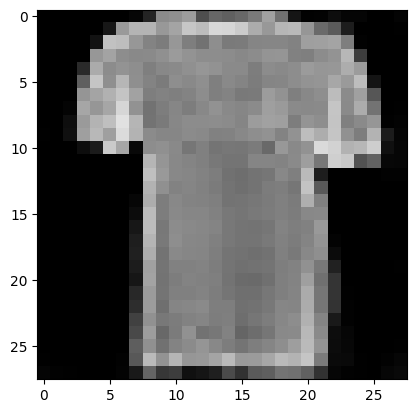

In [ ]:
# Make sure to move the model to eval mode before predicting
gen.eval()

# Generate a batch of noise vectors and class labels
num_images      = 1
fake_noise      = get_noise(num_images, z_dim, device=device)

target_class    = 0
one_hot_labels  = get_one_hot_labels(torch.Tensor([target_class]).long().to(device), n_classes)

# Generate the fake images
with torch.no_grad():
    fake = gen(torch.cat([fake_noise, one_hot_labels.float()],dim=1))

show_tensor_images(fake, num_images=num_images)

# Data set creation

Create a new data set of synthethic images

In [ ]:
import tensorflow as tf
import torch
import numpy as np

# Assuming you have already defined the necessary functions and variables

# Set the number of images per class
n_classes = 10
images_per_class = 3000

# Generate the fake noise using PyTorch
fake_noise = get_noise(images_per_class * n_classes, z_dim, device=device)

# Create empty lists to store the generated fake images and labels
fake_images = []
fake_labels = []

# Generate the fake images and labels for each class
for class_label in range(n_classes):
    # Generate one-hot labels for the current class
    one_hot_labels = get_one_hot_labels(torch.Tensor([class_label]).long().to(device), n_classes)

    # Repeat the one-hot labels to match the size of fake_noise
    one_hot_labels = one_hot_labels.repeat(images_per_class, 1)

    # Generate the fake images for the current class using the PyTorch model
    with torch.no_grad():
        fake = gen(torch.cat([fake_noise[class_label:class_label+images_per_class], one_hot_labels.float()], dim=1))
        fake = torch.reshape(fake, (-1, 28, 28, 1))

    # Convert the one-hot labels to numeric representation
    numeric_labels = torch.argmax(one_hot_labels, dim=1).cpu().numpy()

    if class_label == 0 or class_label == 6: # The most difficult images for the model
      # Append the generated fake images and labels to the lists
      fake_images.append(fake.cpu().numpy())
      fake_labels.append(numeric_labels)

# Concatenate the lists to create the final arrays
fake_images = np.concatenate(fake_images)
fake_labels = np.concatenate(fake_labels)

# Convert the arrays to TensorFlow tensors
fake_images_tf = tf.convert_to_tensor(fake_images)
fake_labels_tf = tf.convert_to_tensor(fake_labels)

# Convert to the standard range of 0 to 255 (original data is in -1 to 1)
fake_images_tf        = (fake_images_tf + 1.0) * 127.5
fake_images_tf_uint8  = tf.cast(fake_images_tf, tf.uint8)

# Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((fake_images_tf_uint8, fake_labels_tf))


In [ ]:
len(dataset)

6000

# Save the dataset to a file

In [ ]:
# Save the dataset
dataset.save(path='/content/gdrive/MyDrive/IA5008/synthetic_fashion_mnist_data_shirts_and_tshirts')

# Plot examples from the generated data set

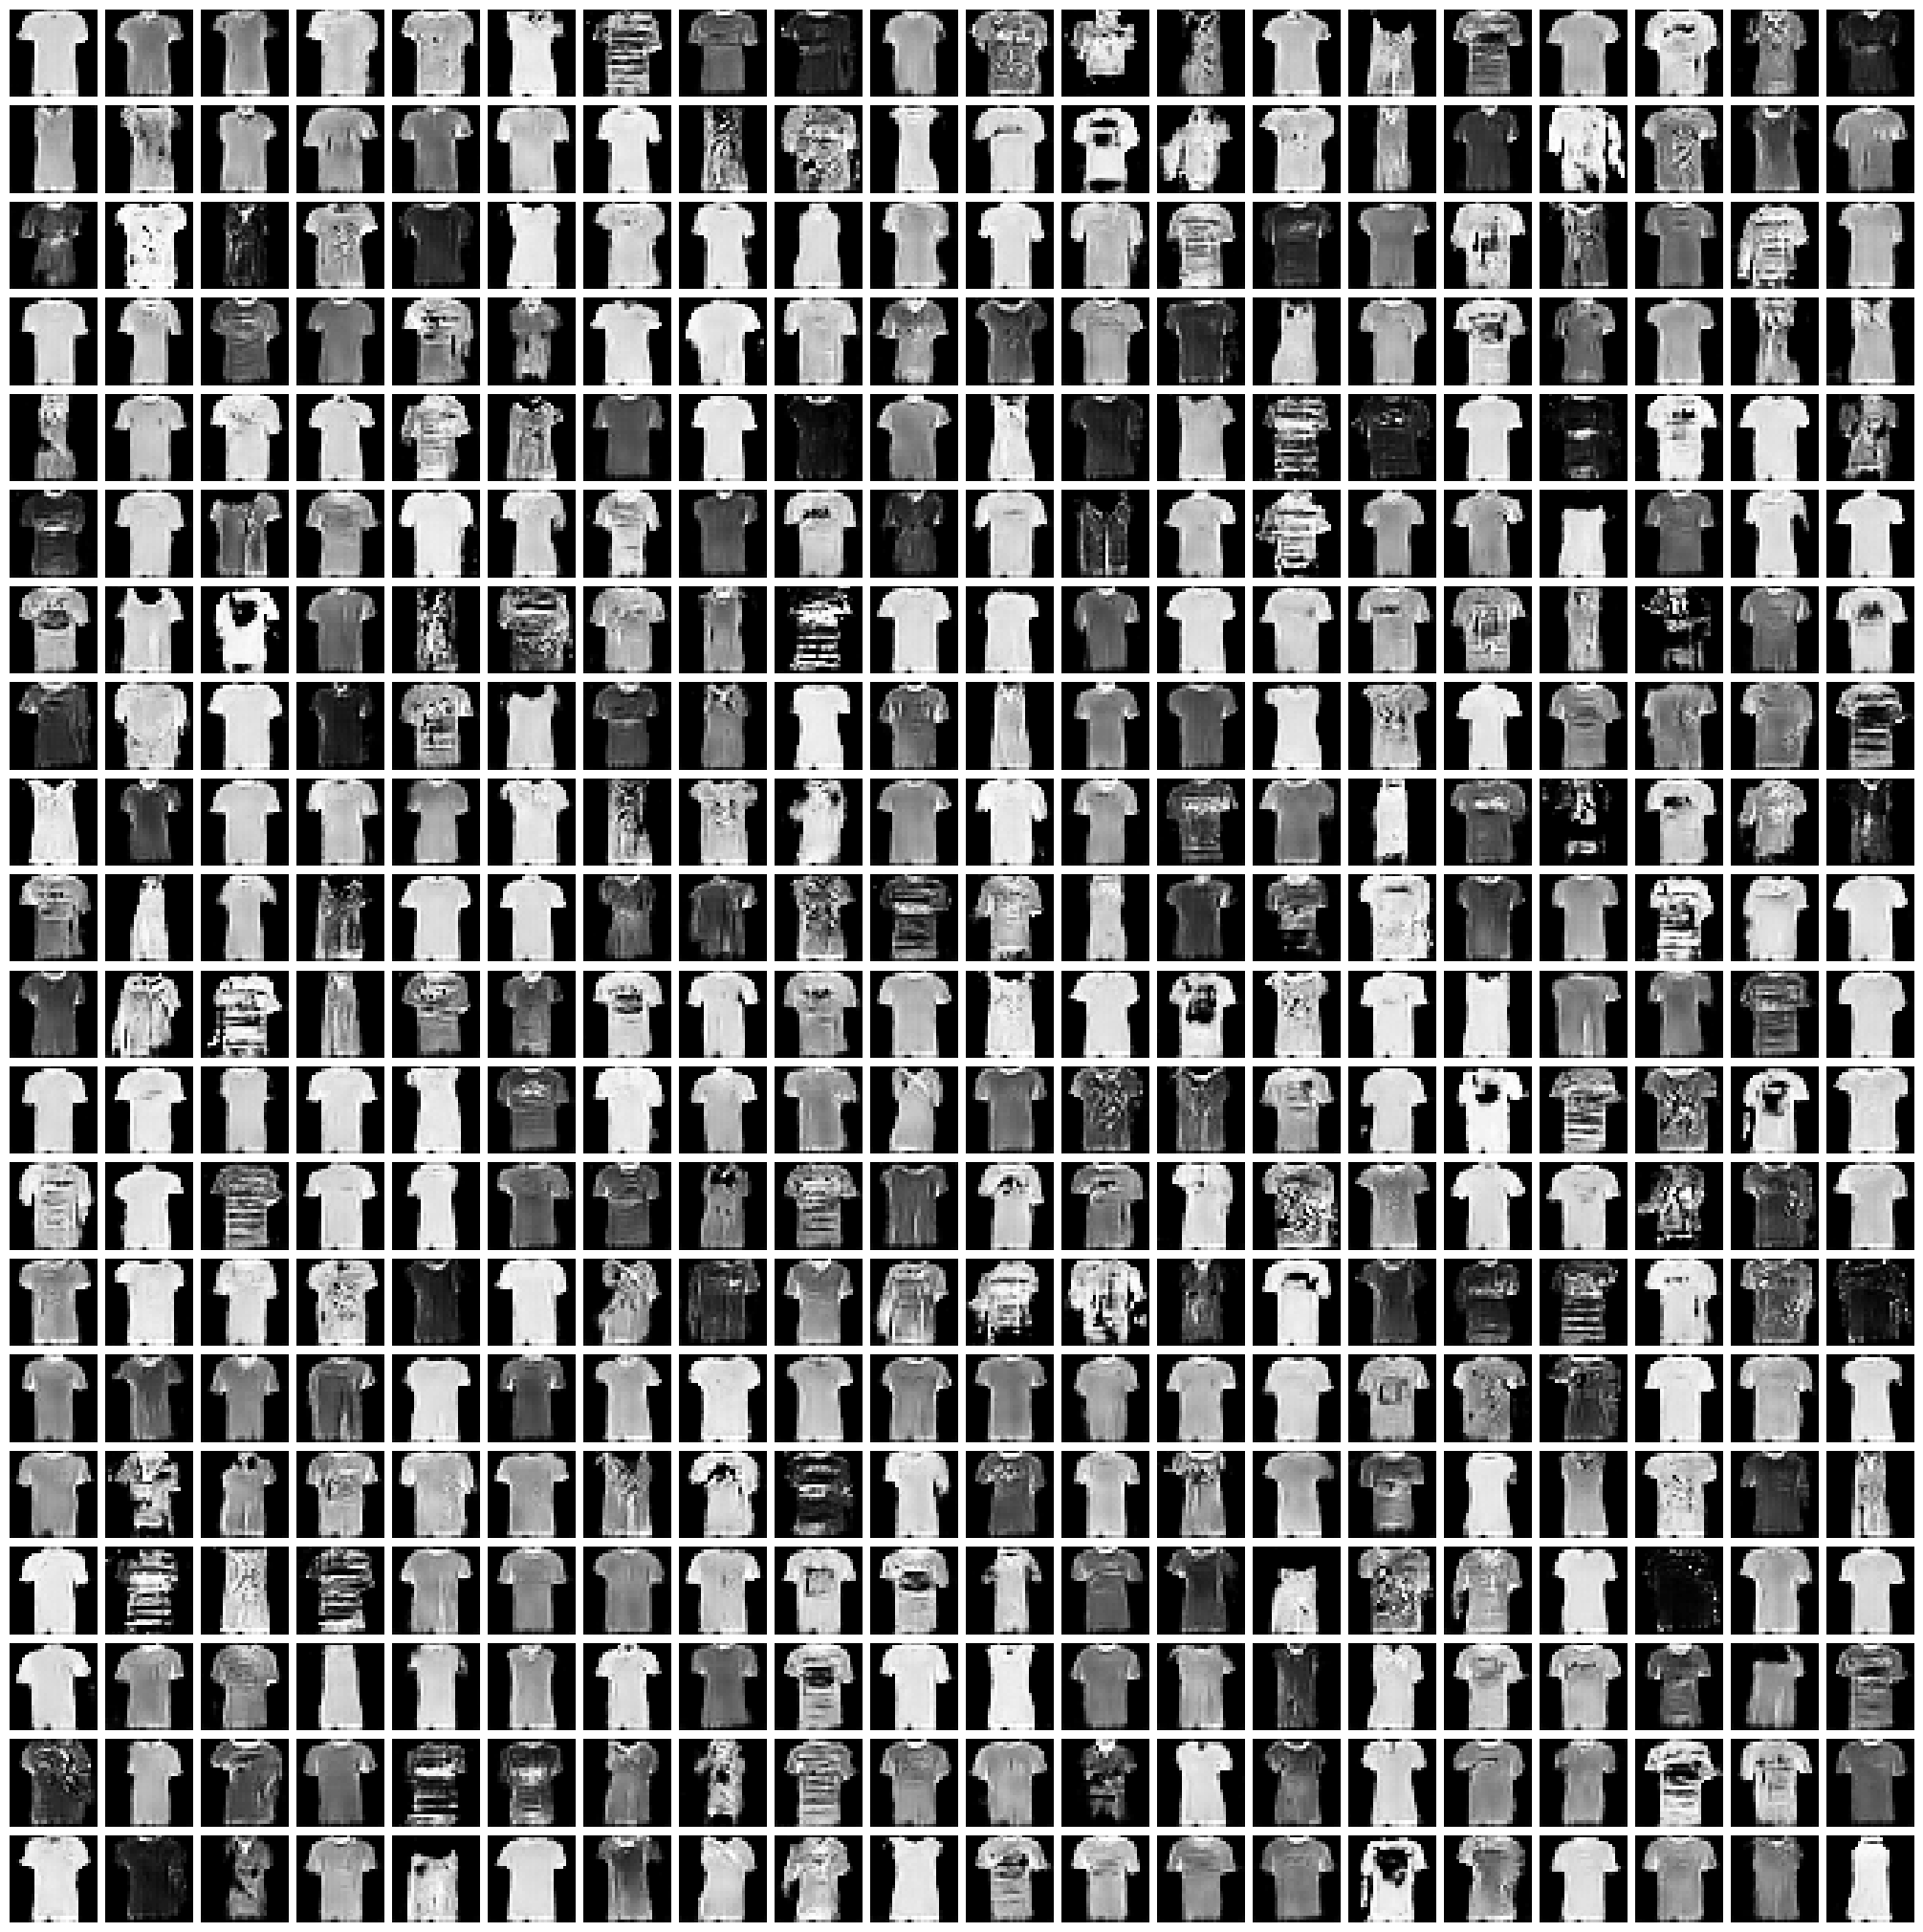

In [ ]:
num_images = 400

# Plot examples of images
fig, axs = plt.subplots(20, 20, figsize=(20, 20))
axs = axs.flatten()

for i, (image, label) in enumerate(dataset.take(num_images)):
    ax = axs[i]
    ax.imshow(image, cmap='gray')
    ax.set_axis_off()  # Remove the axis lines and ticks
    #ax.set_title('Class: ' + str(label.numpy().astype("uint8")))

plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()